In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
import sys

sys.path.append("/home/dchen/BA_CH_EN/")

# Basics
import tensorflow as tf
import xarray as xr
import pandas as pd

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores
from src.models.U_net.unet import Unet
from src.models.U_net.u_net_tests_params import *

<IPython.core.display.Javascript object>

### 0. Setup

In [10]:
var_num = 2
lead_time = 0

<IPython.core.display.Javascript object>

In [11]:
# Helper functions:
def pad_images(images, desired_shape=(128, 144)):
    padded_images = np.pad(
        images,
        (
            (0, 0),  # don't pad along the batch axis
            (
                (desired_shape[0] - images.shape[1]) // 2,
                (desired_shape[0] - images.shape[1]) // 2,
            ),  # pad symmetrically along the height
            (
                (desired_shape[1] - images.shape[2]) // 2,
                (desired_shape[1] - images.shape[2]) // 2,
            ),  # pad symmetrically along the width
            (0, 0),
        ),  # don't pad along the channel axis
        mode="reflect",
    )
    return padded_images


def pad_images_y(images, desired_shape=(128, 144)):
    # Calculate padding for height and width
    pad_height = desired_shape[0] - images.shape[1]
    pad_width = desired_shape[1] - images.shape[2]

    # Distribute padding evenly to both sides, add extra to the end if odd difference
    pad_height_t, pad_height_b = pad_height // 2, pad_height - pad_height // 2
    pad_width_l, pad_width_r = pad_width // 2, pad_width - pad_width // 2

    padded_images = np.pad(
        images,
        (
            (0, 0),  # don't pad along the batch axis
            (pad_height_t, pad_height_b),  # pad symmetrically along the height
            (pad_width_l, pad_width_r),  # pad symmetrically along the width
        ),
        mode="reflect",
    )

    return padded_images

<IPython.core.display.Javascript object>

### 1. Load data

In [14]:
# 1. Load data
dat_train_denorm = ldpd.load_data_all_train_proc_denorm()
dat_test_denorm = ldpd.load_data_all_test_proc_denorm()


# 2. Split Data
dat_X_train_lead_all_denorm, dat_y_train_lead_all_denorm = split_var_lead(
    dat_train_denorm
)
dat_X_test_lead_all_denorm, dat_y_test_lead_all_denorm = split_var_lead(dat_test_denorm)

# 3. Select var and lead_time and change dims
train_data_mean = dat_X_train_lead_all_denorm[var_num][lead_time].isel(mean_std=0)
train_data_std = dat_X_train_lead_all_denorm[var_num][lead_time].isel(mean_std=1)
train_data_y = dat_y_train_lead_all_denorm[var_num][lead_time]

test_data_mean = dat_X_test_lead_all_denorm[var_num][lead_time].isel(mean_std=0)
test_data_std = dat_X_test_lead_all_denorm[var_num][lead_time].isel(mean_std=1)
test_data_y = dat_y_test_lead_all_denorm[var_num][lead_time]

<IPython.core.display.Javascript object>

In [19]:
train_data = np.stack((train_data_mean.values, train_data_std.values), axis=-1)

<IPython.core.display.Javascript object>

In [21]:
train_data.shape

(1429, 120, 130, 2)

<IPython.core.display.Javascript object>

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


def create_datagen(features, labels, batch_size):
    """Create a data generator for the dataset"""
    # Define the data generator
    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
    )

    # Combine the features so that the data generator treats them as a single image with multiple channels
    combined = np.stack((features[..., 0], features[..., 1]), axis=-1)

    # Create a generator
    generator = datagen.flow(combined, labels, batch_size=batch_size)

    while True:
        combined_batch, labels_batch = next(generator)
        yield [combined_batch[..., i] for i in range(combined.shape[-1])], labels_batch


batch_size = 64
augmented_data_gen = create_datagen(train_data, train_data_y, batch_size)

<IPython.core.display.Javascript object>

In [51]:
np.stack((train_data[..., 0], train_data[..., 1]), axis=-1).shape

(1429, 120, 130, 2)

<IPython.core.display.Javascript object>

In [47]:
train_data.shape

(1429, 120, 130, 2)

<IPython.core.display.Javascript object>

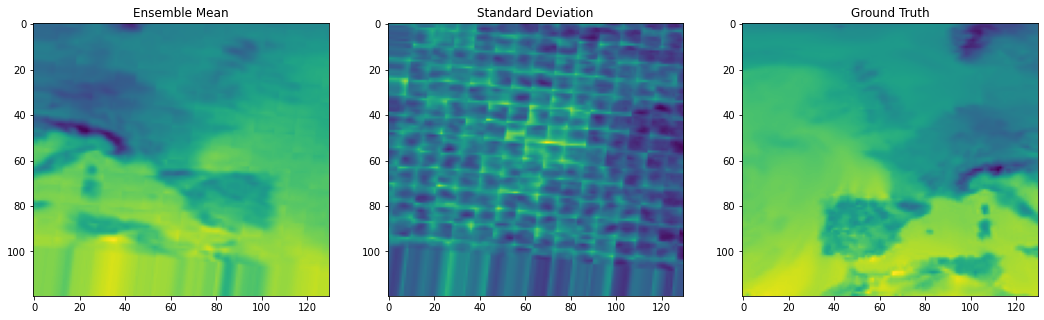

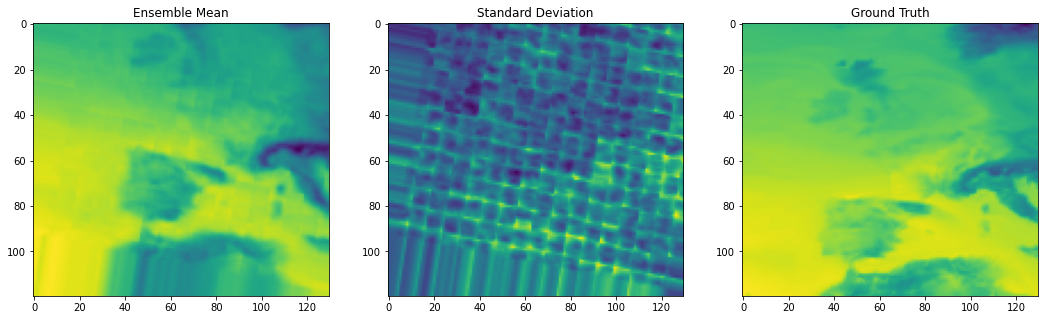

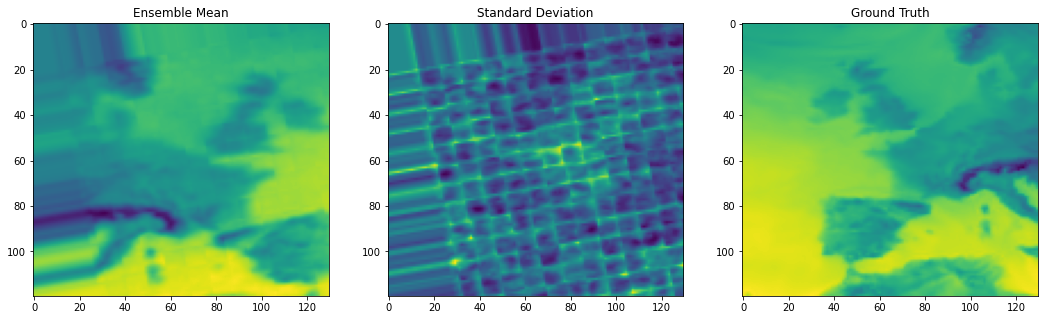

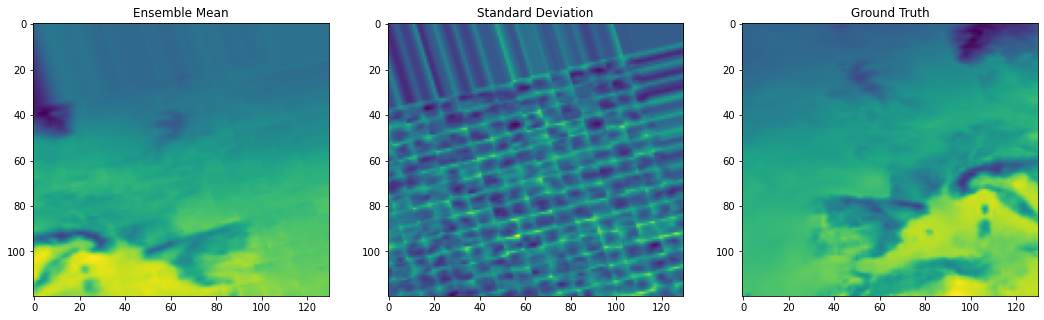

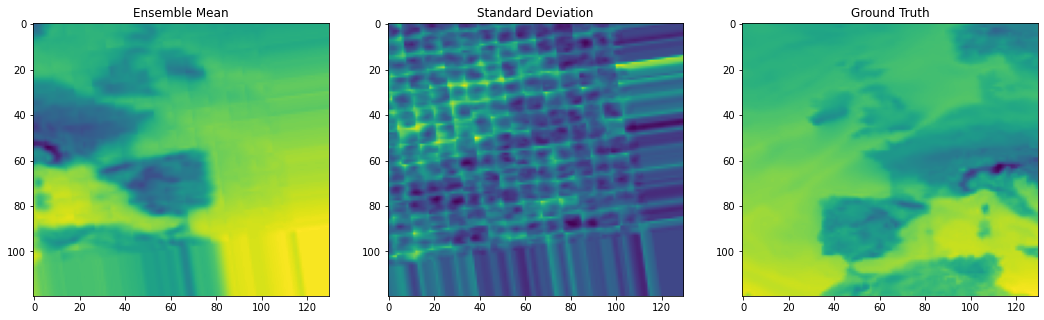

<IPython.core.display.Javascript object>

In [57]:
# Fetch the first batch of augmented images and labels
augmented_images, labels = next(augmented_data_gen)

# Select a pair of augmented image and label
for i in range(5):  # let's visualize first 5 pairs
    image_mean = augmented_images[0][i]
    image_std = augmented_images[1][i]
    label = labels[i]

    # Display the first image's mean and standard deviation channels along with the label
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(image_mean, cmap="viridis")
    axes[0].set_title("Ensemble Mean")
    axes[1].imshow(image_std, cmap="viridis")
    axes[1].set_title("Standard Deviation")
    axes[2].imshow(label, cmap="viridis")
    axes[2].set_title("Ground Truth")
    plt.show()